In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
from tqdm import tqdm

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastprogress import master_bar, progress_bar
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torchvision.models as models
from torchvision.models.efficientnet import _efficientnet_conf, _efficientnet
from functools import partial
import random, os

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)

## Metric

In [2]:
class ParticipantVisibleError(Exception):
    pass
def ariel_score(
        solution,
        submission,
        naive_mean,
        naive_sigma,
        sigma_true
    ):
    '''
    This is a Gaussian Log Likelihood based metric. For a submission, which contains the predicted mean (x_hat) and variance (x_hat_std),
    we calculate the Gaussian Log-likelihood (GLL) value to the provided ground truth (x). We treat each pair of x_hat,
    x_hat_std as a 1D gaussian, meaning there will be 283 1D gaussian distributions, hence 283 values for each test spectrum,
    the GLL value for one spectrum is the sum of all of them.

    Inputs:
        - solution: Ground Truth spectra (from test set)
            - shape: (nsamples, n_wavelengths)
        - submission: Predicted spectra and errors (from participants)
            - shape: (nsamples, n_wavelengths*2)
        naive_mean: (float) mean from the train set.
        naive_sigma: (float) standard deviation from the train set.
        sigma_true: (float) essentially sets the scale of the outputs.
    '''

    if submission.min() < 0:
        raise ParticipantVisibleError('Negative values in the submission')

    n_wavelengths = 283

    y_pred = submission[:, :n_wavelengths]
    # Set a non-zero minimum sigma pred to prevent division by zero errors.
    sigma_pred = np.clip(submission[:, n_wavelengths:], a_min=10**-15, a_max=None)
    y_true = solution

    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true * np.ones_like(y_true)))
    GLL_mean = np.sum(scipy.stats.norm.logpdf(y_true, loc=naive_mean * np.ones_like(y_true), scale=naive_sigma * np.ones_like(y_true)))

    #print(GLL_pred, GLL_true, GLL_mean)
    submit_score = (GLL_pred - GLL_mean)/(GLL_true - GLL_mean)
    return submit_score #float(np.clip(submit_score, 0.0, 1.0))

## Raw data binned 15 time measurements

Unfortunately, I have lost the exact code that I received the dataset with, I really hope that it matches the one in the inference notebook.

In [3]:
train_adc_info = pd.read_csv('../input/ariel-data-challenge-2024/train_adc_info.csv',
                           index_col='planet_id')
train_labels = pd.read_csv('../input/ariel-data-challenge-2024/train_labels.csv',
                           index_col='planet_id')

# pre_train = np.load('./ariel_calibrated_train.npy')
pre_train = pd.read_pickle('../input/pre_train.pkl')

In [4]:
pre_train.shape

(673, 187, 283)

## Transit phase detector

A simple algorithm for finding points where there is a rapid drop in luminosity

In [5]:
def phase_detector(signal):
    
    MIN = np.argmin(signal[30:140])+30
    signal1 = signal[:MIN ]
    signal2 = signal[MIN :]

    first_derivative1 = np.gradient(signal1)
    first_derivative1 /= first_derivative1.max()
    first_derivative2 = np.gradient(signal2)
    first_derivative2 /= first_derivative2.max()

    phase1 = np.argmin(first_derivative1)
    phase2 = np.argmax(first_derivative2) + MIN

    return phase1, phase2

In [6]:

from scipy.optimize import minimize
from scipy import optimize

def objective(s):
    
    best_q = 1e10
    for i in range(4) :
        delta = 2
        x = list(range(signal.shape[0]-delta*4))
        y = signal[:p1-delta].tolist() + (signal[p1+delta:p2 - delta] * (1 + s)).tolist() + signal[p2+delta:].tolist()
        
        z = np.polyfit(x, y, deg=i)
        p = np.poly1d(z)
        q = np.abs(p(x) - y).mean()
    
    if q < best_q :
        best_q = q
    
    return q


all_s = []
for i in tqdm(range(len(train_adc_info))):
    
    signal = pre_train[i,:,1:].mean(axis=1)
    p1,p2 = phase_detector(signal)
 
    r = minimize(
                objective,
                [0.0001],
                method= 'Nelder-Mead'
                  )
    s = r.x[0]
    all_s.append(s)
    
pred_0 = np.repeat(np.array(all_s), 283).reshape((len(all_s), 283))      

100%|██████████| 673/673 [00:10<00:00, 63.15it/s]


## Dataset
We will use (flux - flux_transit) / flux_star as features. If we didn't have a distortion of the star's light, then our targets would be exactly among these signs.

In [7]:
train = pre_train.copy()
for i in range(len(train_adc_info)):
    p1,p2 = phase_detector(pre_train[i,:,1:].mean(axis=1))
    train[i] = (train[i] - pre_train[i,p1:p2].mean(axis=0)) / pre_train[i,list(range(p1-2)) + list(range(p2+2,187))].mean(axis=0) * 1000.0

In [8]:
train = np.concatenate([train,pred_0.reshape(-1,1,283)*1000],axis=1)
train.shape

(673, 188, 283)

In [9]:
np.mean(np.mean(train,axis=0),axis=1).shape

(188,)

In [10]:
np.mean(np.mean(train,axis=0),axis=1)

array([ 2.47505273,  2.48702091,  2.48805286,  2.48753773,  2.48063764,
        2.47541207,  2.48598967,  2.4785061 ,  2.48834143,  2.48047202,
        2.47882843,  2.48535689,  2.48105735,  2.48488807,  2.48156812,
        2.48374713,  2.48449809,  2.47702653,  2.484103  ,  2.47962473,
        2.48618634,  2.48734055,  2.47968715,  2.48444987,  2.48364117,
        2.48565235,  2.47796641,  2.47818333,  2.48380245,  2.48342364,
        2.48753323,  2.47724692,  2.47840724,  2.4816517 ,  2.4805624 ,
        2.47769576,  2.48345254,  2.48242845,  2.48136052,  2.47964103,
        2.47919058,  2.48500363,  2.48433115,  2.48019316,  2.47948694,
        2.4834817 ,  2.48239308,  2.48270309,  2.48078492,  2.48187698,
        2.48371401,  2.48053075,  2.47807532,  2.48000765,  2.47363198,
        2.46111745,  2.43832477,  2.39936341,  2.25968223,  1.90402427,
        1.34469699,  0.76360548,  0.32755752,  0.12145955,  0.05207223,
        0.02505049,  0.00774609, -0.01600226, -0.02911347, -0.04

In [11]:
train.shape

(673, 188, 283)

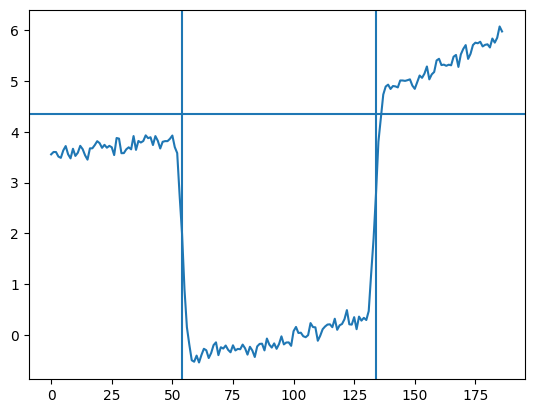

In [20]:
n = 532
# plt.plot(pre_train[n,:,1:].mean(axis=1))
p1, p2 = phase_detector(pre_train[n,:,1:].mean(axis=1))
plt.axvline(p1)
plt.axvline(p2)
plt.plot(train[n,:187,1:].mean(axis=1))
plt.axhline(train[n,:,1:].mean(axis=1)[-1])

## Model 
As a model, I use MobileNet_v2 as the least overfitting. Initially, it accepts a 3-channel image as input, so I added a layer that converts the input into a three-channel one.

The output has 3 numbers for each wavelength corresponding to 0.1587,0.5,0.8413 percentiles.

In [13]:

def create_model_mnet2():
    model = models.mobilenet_v3_small(dropout=0.0, norm_layer = nn.Identity)
    model.features[0][0] = nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.classifier[3] = nn.Linear(in_features=1024, out_features=283*3, bias=True)
    return model

class ImpModel(torch.nn.Module):
    def __init__(self):
        super(ImpModel, self).__init__()

        self.filter = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=(3,1), stride = (2,1), bias=False),
            nn.LeakyReLU()
        )
        self.model_1d = create_model_mnet2()
        
    def forward(self, x):
        x = self.filter(x)
        x = self.model_1d(x)
        return x

## Loss
This loss function predicts not only the value itself, but also its two percentiles. With their help, assuming that the error is distributed normally, we can get an estimate of the standard deviation.

https://www.kaggle.com/code/vyacheslavefimov/quantile-loss-quantile-regression

In [14]:
def q_loss(quantiles, y_pred, target):
    losses = []
    for i, q in enumerate(quantiles):        
        errors = target - y_pred[..., i]
        losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(-1))
    losses = 2 * torch.cat(losses, dim=2)

    return losses


In [15]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
X = list(range(len(train)))

In [ ]:
oof_pred = np.zeros_like(train_labels.values)
oof_sigmas = np.zeros_like(train_labels.values)


In [23]:

for ifold, (train_index, test_index) in enumerate(kf.split(X)):
    if ifold!=1:
        continue
    print('test_index:',test_index)
    train_x = torch.from_numpy(train[train_index]).unsqueeze(1).float()
    train_y = torch.from_numpy(train_labels.values[train_index]).float()
    train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
    training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    val_x = torch.from_numpy(train[test_index]).unsqueeze(1).float()
    val_y = torch.from_numpy(train_labels.values[test_index]).float()
    val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
    validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    model = ImpModel().cuda()

    best_metric = 0
    total_train_losses = []

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 200, eta_min=0, last_epoch=-1)
    for epoch in range(200):
        ep_losses = []        
        model.train()
        for i, data in enumerate(training_loader):
            inputs, labels = data
            optimizer.zero_grad()

            #augmentations: disturb channel and reverse the time
            # if epoch > 0:
            #     for j in range(inputs.shape[-1]):
            #         if np.random.random() > 0.8:
            #             inputs[...,j] = inputs[...,j] * (1 + np.random.randn() * 0.01)
            #     for k in range(inputs.shape[0]):
            #         if np.random.random() > 0.8:
            #             inputs[k] = torch.flip(inputs[k], (1,))

            outputs = model(inputs.cuda()).reshape((inputs.shape[0], 283, 3))

            loss = q_loss([0.1587,0.5,0.8413], outputs, labels.cuda()).mean()
            # print(loss.item())
            loss.backward()

            optimizer.step()

            ep_losses.append(loss.item())

        avg_loss = np.mean(ep_losses)
        total_train_losses.append(avg_loss)

        model.eval()
        running_vloss = 0
        preds = np.zeros((len(val_dataset), 283))
        sigmas = np.zeros((len(val_dataset), 283))
        v_offset = 0
        with torch.no_grad():        
            for i, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata
                voutputs = model(vinputs.cuda()).reshape((vinputs.shape[0], 283, 3))
                preds[v_offset:v_offset+len(vinputs)] = voutputs[:,:,1].detach().cpu().numpy()
                sigmas[v_offset:v_offset+len(vinputs)] = voutputs[:,:,2].detach().cpu().numpy() - voutputs[:,:,0].detach().cpu().numpy()
                vloss = q_loss([0.1587,0.5,0.8413], voutputs, vlabels.cuda()).mean()
                running_vloss += vloss
                v_offset += len(vinputs)

        avg_vloss = running_vloss / (i + 1)
        sigmas_new = np.zeros((len(val_dataset), 283))+14e-5

        metric = ariel_score(        
            train_labels.values[test_index],
            np.concatenate([preds.clip(0), sigmas_new.clip(0)], axis=1), 
            train_labels.values[test_index].mean(),
            train_labels.values[test_index].std(),
            sigma_true=1e-5)
        
        print('fold {} epoch {} train {} valid {} metric {}'.format(ifold, epoch, 
                                                                    round(avg_loss*100,3), 
                                                                    round(avg_vloss.item()*100,3), 
                                                                    round(metric,3) ))
        scheduler.step()
        
    oof_pred[test_index] = preds
    oof_sigmas[test_index] = sigmas
    torch.save(model.state_dict(), 'purple_hat_{}'.format(ifold))
    del model

test_index: [135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260
 261 262 263 264 265 266 267 268 269]
fold 1 epoch 0 train 0.561 valid 0.243 metric -49.756
fold 1 epoch 1 train 0.161 valid 0.117 metric -19.108
fold 1 epoch 2 train 0.112 valid 0.098 metric -13.126
fold 1 epoch 3 train 0.103 valid 0.095 metric -13.337
fold 1 epoch 4 train 0.101 valid 0.093 metric -15.321
fold 1 epoch 5 train 0.1 valid 0.1 metric -12.613
fold 1 epoch 6 train 0.104 valid 0.098 metric -13.394
fold 1 epoch 7 train 0.104 valid 0.097 metric -13.718
fold 1 epoc

In [24]:
ariel_score(        
            train_labels.values,
            np.concatenate([oof_pred.clip(0), oof_sigmas.clip(0)], axis=1), 
            train_labels.values.mean(),
            train_labels.values.std(),
            sigma_true=1e-5)

0.5328085092112373

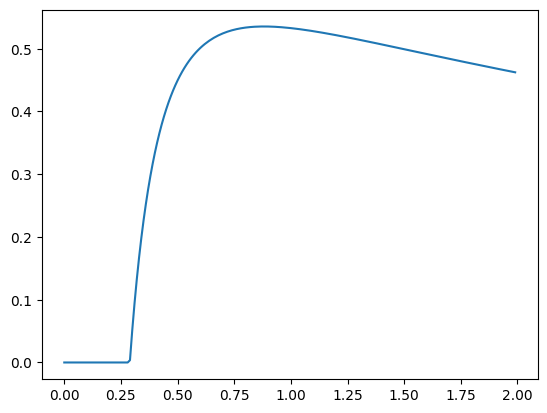

In [26]:
xs,ys = [], []
for i in range(200):
    xs.append(i/100.0)
    ys.append(ariel_score(        
            train_labels.values,
            np.concatenate([oof_pred.clip(0), oof_sigmas.clip(0) * (i / 100.0)], axis=1), 
            train_labels.values.mean(),
            train_labels.values.std(),
            sigma_true=1e-5))
plt.plot(xs, np.array(ys).clip(0))

In [8]:
wavelen = pd.read_csv('../input/ariel-data-challenge-2024/wavelengths.csv')

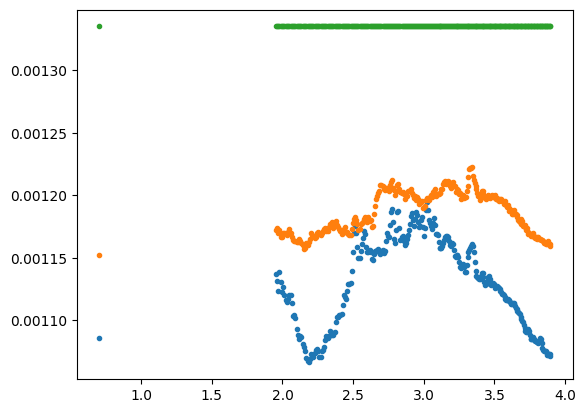

In [9]:
plt.plot(wavelen.values[0],train_labels.iloc[0].values,'.')
plt.plot(wavelen.values[0],oof_pred[0],'.')
plt.plot(wavelen.values[0],pred_0[0],'.')

